<a href="https://colab.research.google.com/github/benoitrolland/ncps/blob/master/ncp_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we have to download and install the pip package

In [1]:
!pip3 install -U ncps pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 54.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data

For the training we will use Pytorch-Lightning, thus we have to define our learner module.

In [3]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


Next we define some toy dataset and create the corresponding DataLoaders

data_x.size:  torch.Size([1, 48, 2])
data_y.size:  torch.Size([1, 48, 1])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


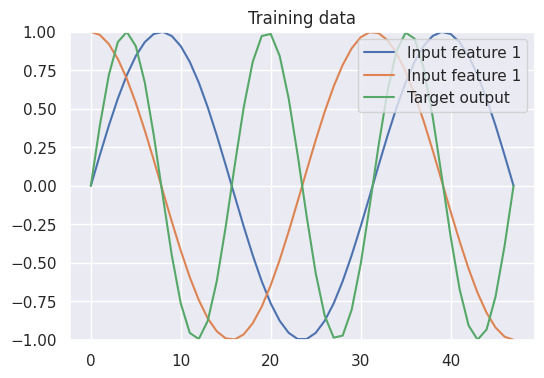

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

in_features = 2
out_features = 1
N = 48  # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
print("data_x.size: ", str(data_x.size()))
print("data_y.size: ", str(data_y.size()))
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)
# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 1")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

Here we can finally create a LTCCell and make use of the predefined

*   Élément de liste
*   Élément de liste

sparse wiring structures of the keras-ncp package. For simplicity we will just define a fully-connected RNN

In [7]:
wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    accelerator="auto",
    #gpus=0,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


alloc!


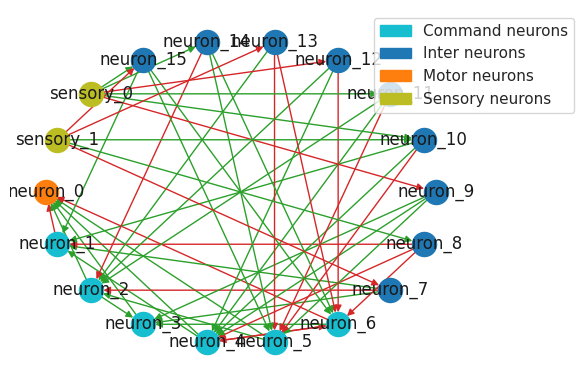

In [9]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True,  neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

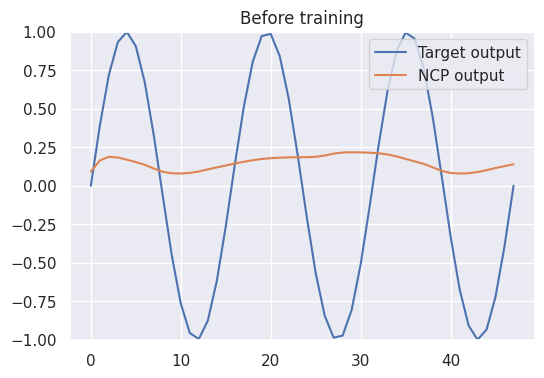

In [10]:
sns.set()
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

... and train our network

In [11]:
trainer.fit(learn, dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 1.5 K 
-------------------------------
1.2 K     Trainable params
288       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_light

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


In [12]:
results = trainer.test(learn, dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │  0.00010759202996268868   │
└───────────────────────────┴───────────────────────────┘

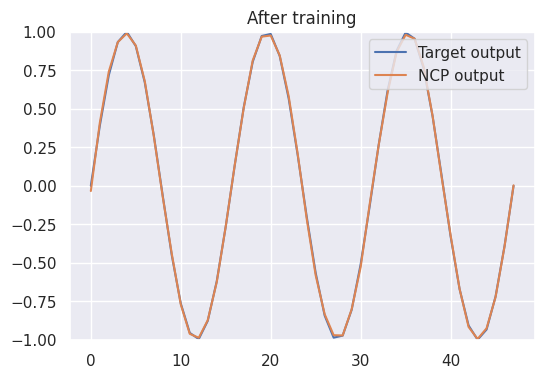

In [13]:
sns.set()
with torch.no_grad():
  prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()